In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
%matplotlib inline

In [ ]:
# Yahoo Finance has a nice API
import yfinance as yahooFinance
# GetInformation = yahooFinance.Ticker("^IXIC")
GetInformation = yahooFinance.Ticker("MSFT")
df = GetInformation.history(period="max")
print(df.head(4))
df.plot(y=['Open','Close'])
plt.show()

In [ ]:
def create_time_windows(df, n_window ,n_forecast, scale=True ): 
    '''
        This creates a rolling time window (X,y) from the Pandas DataFrame df, and store it in a numpy array of size (nsamples, n_window/n_forecast, nfeatures)
        n_features referr to open/close/volume etc, while also going through a min-max scaler from -1 to 1 for all time windows
    '''
    N, N_features = len(df), len(list(df))
    X, y = [], []
    # sc = MinMaxScaler(feature_range=(0,1))
    sc = MaxAbsScaler()
    for i in range(n_window,N-n_forecast):
        # X.append(df.iloc[(i-n_window):i].to_numpy())
        # y.append(df.iloc[i:(i+n_forecast)].to_numpy())
        tmp = df.iloc[(i-n_window):(i+n_forecast)].to_numpy()
        if scale:
            tmp = sc.fit_transform(tmp)
        X.append(tmp[:n_window,...])
        y.append(tmp[n_window:,...])

    # for i in range(N):
    #     if (i+1) * (n_window+n_forecast) <= N:
    #         tmp = df.iloc[(i * (n_window+n_forecast)):((i+1)*(n_window+n_forecast))].to_numpy()
    #         tmp = sc.fit_transform(tmp)
    #         X.append(tmp[:n_window,...])
    #         y.append(tmp[n_window:,...])
        
    return np.array(X), np.array(y)

In [13]:
n_window, n_forecast = 8*5, 1
df1 = pd.DataFrame({'Return':df['Close'] - df['Open']})
# use MaxAbsScaler, therefore preserving 0 to be the zero return. 
X, y = create_time_windows(df1, n_window = n_window, n_forecast = n_forecast, scale=True)

Nsamples = X.shape[0]
Ntrain = int(Nsamples * 0.8) 
Xtrain, ytrain = X[:Ntrain,...], y[:Ntrain,...]
Xtest, ytest = X[Ntrain:,...], y[Ntrain:,...]

nfeatures = 1 # only use first nfeature columns for training and prediction
model5= keras.Sequential([keras.Input(shape=(None,nfeatures)),
                          keras.layers.SimpleRNN(64,return_sequences=False),
                          keras.layers.Dense(n_forecast)])
model5.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
ntrain = int(Xtrain.shape[0]*0.8)
history = model5.fit(Xtrain[:ntrain,:,:nfeatures],ytrain[:ntrain,:,0], batch_size= 32,
                     epochs = 100,validation_data=(Xtrain[ntrain:,:,:nfeatures],ytrain[ntrain:,:,0]))
model5.save('models/Classification_SimpleRNN_Return_NextDay_May28_920PM.keras')

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1815 - val_loss: 0.1471
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1629 - val_loss: 0.1463
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1600 - val_loss: 0.1440
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1671 - val_loss: 0.1429
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1597 - val_loss: 0.1422
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1653 - val_loss: 0.1423
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1630 - val_loss: 0.1424
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1601 - val_loss: 0.1429
Epoch 9/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1630 - val_loss: 0.1415
Epoch 10/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1652 - val_loss: 0.1424
Epoch 11/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1609 - val_loss: 0.1444
Epoch 12/100
192/192 ━━━━━━━━━━━━━━━━━━━━

In [10]:
Xtest.shape

(1918, 40, 1)

In [15]:
def plot_regression_results(X,y,model=0,mode='test'):
  fig, ax = plt.subplots(4,4,figsize=(8,6),sharex=True,sharey=True)
  for r in range(4):
    for c in range(4):
        idx = np.random.randint(X.shape[0])
        ax[r,c].plot(range(X.shape[1]),X[idx,:,0],"b-",label='train')
        ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),y[idx,:,0],"r-^",label='actual',ms=3)
        if model != 0:
            val = model(X[idx:(idx+1),:,:1])
            ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),val[0],"g-x",label='pred.',ms=3)
        if r ==0 and c ==0:
          ax[r,c].legend(fontsize=9)
  fig.suptitle(mode)
  plt.tight_layout()
  plt.show()
  plt.close()

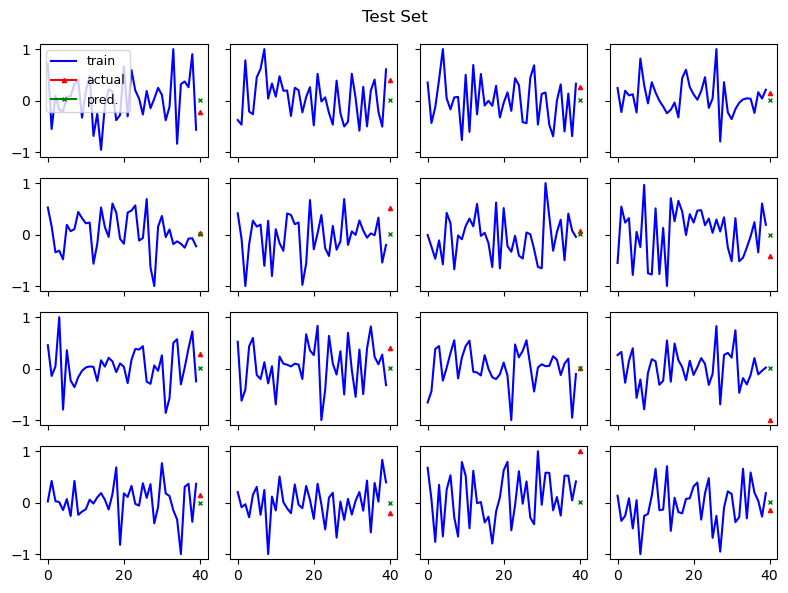

In [16]:
plot_regression_results(Xtest,ytest,model=model5,mode='Test Set')